# StatQuest: Long Short-Term Memory (LSTM) with PyTorch + Lightning!!!
## Sponsored by...
[<img src="./images/Brandmark_FullColor_Black.png" alt="Lightning" style="width: 400px;">](https://lightning.ai/)

Copyright 2022, Joshua Starmer

---- 
**NOTE:** This tutorial is from the StatQuest **[Long Short-Term Memory with PyTorch + Lightning](https://youtu.be/RHGiXPuo_pI)**.

In this tutorial, we will use **[PyTorch](https://pytorch.org/) + [Lightning](https://lightning.ai/)** to create, optimize and make predictions using the **Long Short-Term Memory (LSTM)** network featured in the **StatQuest** **[Long Short-Term Memory, Clearly Explained!!!](https://youtu.be/YCzL96nL7j0)** In that **StatQuest**, we implemented a **Long Short-Term Memory** unit, seen below, that uses predicts sequential data to predict the value of two different companies.
<!-- <img src="./xgboost_tree.png" alt="An XGBoost Tree" style="width: 600px;"> -->

<img src="./images/lstm_image.001.png" alt="A Long Short-Term Memory Unit" style="width: 1620px;">

The training data (below) consist of stock prices for two different companies, **Company A** and **Company B**. The goal is to use the data from the first **4** days to predict what the price will be on the **5**th day. If you look closely at the data, you'll see that the only differences in the prices occur on Day **1** and Day **5**. So the LSTM has to remember what happened on Day **1** in order to predict what will happen on Day **5**.


<img src="./images/company_a_data.png" alt="Data for Company A" style="width: 450px;"> <img src="./images/company_b_data.png" alt="Data for Company B" style="width: 450px;">


In this tutorial, you will...

- **[Build a Long Short-Term Memory (LSTM) unit by hand with Lightning](#build)**

- **[Train the LSTM unit and use Lightning and TensorBoard to evaluate](#train)**

- **[Add additional epochs to the training without starting over](#add_epochs)**

- **[Build a Long Short-Term Memory Unit with nn.LSTM() and train it with Lightning](#nnLSTM)**

#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the <!-- basics of **[PyTorch](https://youtu.be/FHdlXe1bSe4)** and the  --> theory behind **[Neural Networks](https://youtu.be/CqOfi41LfDw)**, **[Backpropagation](https://youtu.be/IN2XmBhILt4)**, and **[Long Short-Term Memory](https://youtu.be/YCzL96nL7j0)**. If not, check out the **'Quests** by clicking on the links for each topic.

#### ALSO NOTE:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

-----

# Import the modules that will do all the work

**TL;DR** For the most part, this is the same as the **The StatQuest Introduction to Coding Neural Networks with PyTorch + Lightning**, except now we don't have to draw our own graphs, so we are omitting `matplotlib` and `seaborn`. Also, instead of using **Stochastic Gradient Descent** to optimize the weights and biaes, we are using **Adam** and we're also importing a function that allows us to set the seed for the random numbers we use to initialize the Weights and Biases. So, with that said...

The very first thing we need to do is load a bunch of Python modules. Python itself is just a basic programming language. These modules give us extra functionality to create a Long Short-Term Memory (LSTM) neural network and optimize the neural network's parameters.

**NOTE:** You will need **Python 3.8** and have at least these versions for each of the following modules: 
- pytorch >= 1.10.1
- lightning >= 1.8.0

### If you installed **Python** with [Anaconda](https://www.anaconda.com/)...
...then you can check which versions of each package you have with the command: `conda list`. If, for example, your version of `matplotlib` is older than **3.3.4**, then the easiest thing to do is just update all of your Anaconda packages with the following command: `conda update --all`. However, if you only want to update `matplotlib`, then you can run this command: `conda install matplotlib=3.3.4`.

### If you need to install **PyTorch**...
...then the easiest thing to do is follow the instructions on the [PyTorch website](https://pytorch.org/get-started/locally/).

### If you need to install **Lightning**...
...then the easiest thing to do is follow the instructions on the [Lightning AI website](https://lightning.ai/).

In [1]:
import torch # torch will allow us to create tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import Adam # optim contains many optimizers. This time we're using Adam

import pytorch_lightning as L
from torch.utils.data import TensorDataset, DataLoader # these are needed for the training data

## Set the seed so that, hopefully, everyone will get the same results as me.
from pytorch_lightning.utilities.seed import seed_everything

import numpy as np

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')

from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

c:\Users\patbo\.conda\envs\theoryML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn,False,splitdata=True, stdzr='minmax')
print(X_train.shape)
print(T_train.shape)
# X,T = market_prepro(f,st,sn,False,splitdata=False)

dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train['Open'], T_train, 4, 1,None)
dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test['Open'], T_test, 4, 1,  None)
# dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train['Open'], T_train, 3, 1, [ 'Year', 'Month' ,'Day_date', 'Day'])
# dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test['Open'], T_test, 3, 1, [ 'Year', 'Month' ,'Day_date', 'Day'])

(1044, 11)
(1044,)


----

<a id="build"></a>
# Build a Long Short-Term Memory unit by hand using PyTorch + Lightning

Just like we have done in previous tutorials, building a neural network, and a Long Short-Term Memory (LSTM) unit is a type of neural network, means we need to create a new class. To make it easy to train the LSTM, this class will inherit from `LightningModule` and we'll create the following methods:
- `__init__()` to initialize the Weights and Biases and keep track of a few other house keeping things.
- `lstm_unit()` to do the LSTM math. For example, to calculate the percentage of the long-term memory to remember.
- `forward()` to make a forward pass through the unrolled LSTM. In other words `forward()` calls `lstm_unit()` for each data point.
- `configure_optimizers()` to configure the opimimizer. In the past, we have use `SGD` (Stochastic Gradient Descent), however, in this tutorial we'll change things up and use `Adam`, another popular algorithm for optimizing the Weights and Biases.
- `training_step()` to pass the training data to `forward()`, calculate the loss and to keep track of the loss values in a log file.

In [28]:
## Here we are implementing an LSTM network by hand...
class LSTMbyHand(L.LightningModule):

    def __init__(self):
        
        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        seed_everything(seed=42)
        
        ###################
        ##
        ## Initialize the tensors for the LSTM
        ##
        ###################
        
        ## NOTE: nn.LSTM() uses random values from a uniform distribution to initialize the tensors
        ## Here we can do it 2 different ways 1) Normal Distribution and 2) Uniform Distribution
        ## We'll start with the Normal Distribtion...
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)        
        
        ## NOTE: In this case, I'm only using the normal distribution for the Weights.
        ## All Biases are initialized to 0.
        ##
        ## These are the Weights and Biases in the first stage, which determines what percentage
        ## of the long-term memory the LSTM unit will remember.
        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        ## These are the Weights and Biases in the second stage, which determins the new
        ## potential long-term memory and what percentage will be remembered.
        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        ## These are the Weights and Biases in the third stage, which determines the
        ## new short-term memory and what percentage will be sent to the output.
        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        ## We can also initialize all Weights and Biases using a uniform distribution. This is
        ## how nn.LSTM() does it.
#         self.wlr1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wlr2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.blr1 = nn.Parameter(torch.rand(1), requires_grad=True)

#         self.wpr1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wpr2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bpr1 = nn.Parameter(torch.rand(1), requires_grad=True)

#         self.wp1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wp2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bp1 = nn.Parameter(torch.rand(1), requires_grad=True)
        
#         self.wo1 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.wo2 = nn.Parameter(torch.rand(1), requires_grad=True)
#         self.bo1 = nn.Parameter(torch.rand(1), requires_grad=True)
        
        
    def lstm_unit(self, input_value, long_memory, short_memory):
        ## lstm_unit does the math for a single LSTM unit.
        
        ## NOTES:
        ## long term memory is also called "cell state"
        ## short term memory is also called "hidden state"
        
        ## 1) The first stage determines what percent of the current long-term memory
        ##    should be remembered
        long_remember_percent = torch.sigmoid((short_memory * self.wlr1) + 
                                              (input_value * self.wlr2) + 
                                              self.blr1)
        
        ## 2) The second stage creates a new, potential long-term memory and determines what
        ##    percentage of that to add to the current long-term memory
        potential_remember_percent = torch.sigmoid((short_memory * self.wpr1) + 
                                                   (input_value * self.wpr2) + 
                                                   self.bpr1)
        potential_memory = torch.tanh((short_memory * self.wp1) + 
                                      (input_value * self.wp2) + 
                                      self.bp1)
        
        ## Once we have gone through the first two stages, we can update the long-term memory
        updated_long_memory = ((long_memory * long_remember_percent) + 
                       (potential_remember_percent * potential_memory))
        
        ## 3) The third stage creates a new, potential short-term memory and determines what
        ##    percentage of that should be remembered and used as output.
        output_percent = torch.sigmoid((short_memory * self.wo1) + 
                                       (input_value * self.wo2) + 
                                       self.bo1)         
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        
        ## Finally, we return the updated long and short-term memories
        return([updated_long_memory, updated_short_memory])
        
    
    def forward(self, input): 
        ## forward() unrolls the LSTM for the training data by calling lstm_unit() for each day of training data 
        ## that we have. forward() also keeps track of the long and short-term memories after each day and returns
        ## the final short-term memory, which is the 'output' of the LSTM.

       
        long_memory = 0 # long term memory is also called "cell state" and indexed with c0, c1, ..., cN
        short_memory = 0 # short term memory is also called "hidden state" and indexed with h0, h1, ..., cN
        if (len(input.shape) == 1):
            day1 = input[0]
            day2 = input[1]
            day3 = input[2]
            day4 = input[3]
        else:
            day1 = input[0,0]
            day2 = input[0,1]
            day3 = input[0,2]
            day4 = input[0,3]
        
        ## Day 1
        long_memory, short_memory = self.lstm_unit(day1, long_memory, short_memory)
        
        ## Day 2
        long_memory, short_memory = self.lstm_unit(day2, long_memory, short_memory)
        
        ## Day 3
        long_memory, short_memory = self.lstm_unit(day3, long_memory, short_memory)
        
        ## Day 4
        long_memory, short_memory = self.lstm_unit(day4, long_memory, short_memory)
        
        ##### Now return short_memory, which is the 'output' of the LSTM.
        return short_memory
        
        
    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        # return Adam(self.parameters(), lr=0.1) # NOTE: Setting the learning rate to 0.1 trains way faster than
                                                 # using the default learning rate, lr=0.001, which requires a lot more 
                                                 # training. However, if we use the default value, we get 
                                                 # the exact same Weights and Biases that I used in
                                                 # the LSTM Clearly Explained StatQuest video. So we'll use the
                                                 # default value.
        return Adam(self.parameters())

    
    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_i, label_i = batch # collect input
        output_i = self.forward(input_i[0]) # run input through the neural network
        loss = (output_i - label_i)**2 ## loss = squared residual
        
        ###################
        ##
        ## Logging the loss and the predicted values so we can evaluate the training
        ##
        ###################
        self.log("train_loss", loss)
        ## NOTE: Our dataset consists of two sequences of values representing Company A and Company B
        ## For Company A, the goal is to predict that the value on Day 5 = 0, and for Company B,
        ## the goal is to predict that the value on Day 5 = 1. We use label_i, the value we want to
        ## predict, to keep track of which company we just made a prediction for and 
        ## log that output value in a company specific file
        if (label_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)
            
        return loss

Once we have created the class that defines an LSTM, we can use it to create a model and print out the randomly initialized Weights and Biases. Then, just for fun, we'll see what those random Weights and Biases predict for **Company A** and **Company B**. If they are good predictions, then we're done! However, the chances of getting good predictions from random values is very small. :(

In [29]:
## Create the model object, print out parameters and see how well
## the untrained LSTM can make predictions...
model = LSTMbyHand() 

print("Before optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

print("\nNow let's compare the observed and predicted values...")
## NOTE: To make predictions, we pass in the first 4 days worth of stock values 
## in an array for each company. In this case, the only difference between the
## input values for Company A and B occurs on the first day. Company A has 0 and
## Company B has 1.
print("Company A: Observed = 0, Predicted =", 
      model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", 
      model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

Global seed set to 42


Before optimization, the parameters are...
wlr1 tensor(0.3367)
wlr2 tensor(0.1288)
blr1 tensor(0.)
wpr1 tensor(0.2345)
wpr2 tensor(0.2303)
bpr1 tensor(0.)
wp1 tensor(-1.1229)
wp2 tensor(-0.1863)
bp1 tensor(0.)
wo1 tensor(2.2082)
wo2 tensor(-0.6380)
bo1 tensor(0.)

Now let's compare the observed and predicted values...
Company A: Observed = 0, Predicted = tensor(-0.0377)
Company B: Observed = 1, Predicted = tensor(-0.0383)


With the unoptimized paramters, the predicted value for **Company A**, **-0.0377**, isn't terrible, since it is relatively close to the observed value, **0**. However, the predicted value for **Company B**, **-0.0383**, _is_ terrible, because it is relatively far from the observed value, **1**. So, that means we need to train the LSTM.

Small bam. 

----

<a id="train"></a>
# Train the LSTM unit and use Lightning and TensorBoard to evaluate: Part 1 - Getting Started

Since we are using **Lightning** training, training the LSTM we created by hand is pretty easy. All we have to do is create the training data and put it into a `DataLoader`...

In [23]:
## create the training data for the neural network.
inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1., 0.5, 0.25, 1.]])
labels = torch.tensor([0., 1.])

dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

...and then create a **Lightning Trainer**, `L.Trainer`, and fit it to the training data. **NOTE:** We are starting with **2000** epochs. This may be enough to successfully optimize all of the parameters, but it might not. We'll find out after we compare the predictions to the observed values.

In [30]:
trainer = L.Trainer(max_epochs=10) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
trainer.fit(model, train_dataloaders=dl_train)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1039/1039 [00:29<00:00, 34.80it/s, loss=0.000561, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1039/1039 [00:29<00:00, 34.78it/s, loss=0.000561, v_num=8]


Now that we've trained the model with **2000** epochs, we can see how good the predictions are...

In [34]:
def makepred(model, dataset):
    y = []
    t = []
    for ii in dataset:
        feat, lab = ii

        y.append(model.forward(feat).detach().numpy())
        t.append(lab.numpy()[0])

    return y, t


In [35]:
y_test, t_test = makepred(model, ds_test)
y_train, t_train = makepred(model, ds_train)

In [36]:
from sklearn.metrics import (mean_absolute_percentage_error,
                             r2_score,
)

train_mape = mean_absolute_percentage_error(t_train, y_train)
test_mape = mean_absolute_percentage_error(t_test, y_test)



print('Training MAPE ', train_mape)
print('Testing MAPE ', test_mape)

print('Training r2 ', r2_score(t_train, y_train) )
print('Testing r2 ', r2_score(t_test, y_test) )

Training MAPE  884886744615.1436
Testing MAPE  1280395358268.3088
Training r2  0.9865142126705327
Testing r2  0.9720515882454238


In [37]:
import matplotlib.pyplot as plt

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

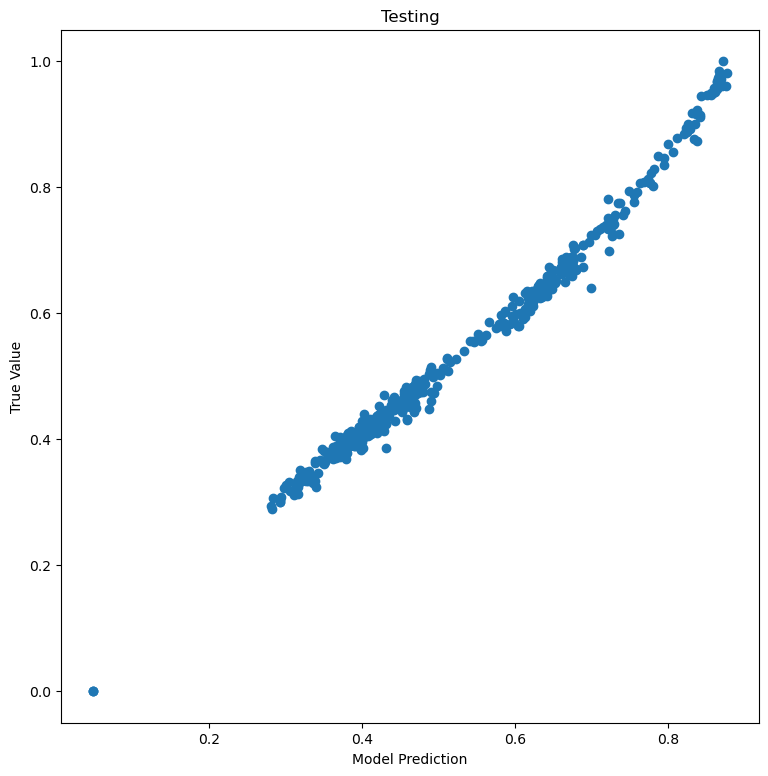

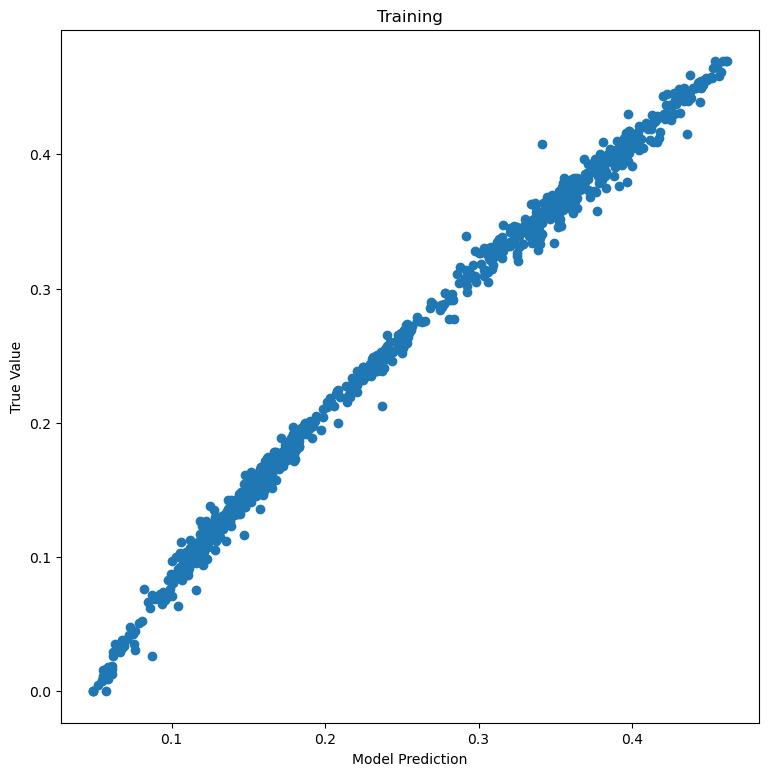

In [38]:
scatter_results(y_test, t_test, 'Testing')
scatter_results(y_train, t_train, 'Training')

In [ ]:
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =", model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

Unfortunately, these predictions are terrible. :( So it seems like we'll have to do more training. However, it would be awesome if we could be confident that more training will actually improve the predictions. If not, we can spare ourselves a lot of time, and potentially money, and just give up. So, before we dive into more training, let's look at the loss values and predictions that we saved in log files with **TensorBoard**. **TensorBoard** will graph everything that we logged during training, making it super easy to see if things are headed in the right direction or not.

To get TensorBoard working
- In the Jupyter browser window, go to the **File** menu and select **New**.
- In the submenu, select **Terminal**.
- In the terminal, navigate to the same directory that contains the **lightning_logs** directory.
- Then in the terminal, enter `tensorboard --logdir=lightning_logs/` to start the **TensorBoard** server.
- When the **TensorBoard** server starts, it will print out a URL that looks like this `http://localhost:6006/`. Copy the URL and paste it into a new browser window and then you are good to go!!! 
- BAM!!!

Below are the graphs of **loss** (`train_loss`), the predictions for **Company A** (`out_0`), and the predictions for **Company B** (`out_1`). Remember for **Companay A**, we want to predict **0** and for **Company B**, we want to predict **1**.

<img src="./images/train_loss_2000_epochs.png" alt="Loss" style="width: 300px;"> <img src="./images/out_0_2000_epochs.png" alt="out_0" style="width: 300px;"> <img src="./images/out_1_2000_epochs.png" alt="out_1" style="width: 300px;">

**NOTE:** If your graphs look messed up and you see a bunch of different lines, instead of just one red line per graph, then check where this notebook is saved for a directory called `lightning_logs`. Delete `lightning_logs` and the re-run everything in this notebook. One source of problems with the graphs is that every time we train a model, a new batch of log files is created and stored in `lightning_logs` and **TensorBoard**, by default, will plot all of them. You can turn off unwanted log files in **TensorBoard**, and we'll do this later on in this notebook, but for now, the easiest thing to do is to start with a clean slate.

Anyway, if we look at the **loss** (`train_loss`), we see that it is going down, which is good, but it still has further to go. When we look at the predictions for **Company A** (`out_0`), we see that they started out pretty good, close to **0**, but then got really bad early on in training, shooting all the way up to **0.5**, but are starting to get smaller. In contrast, when we look at the predictions for **Company B** (`out_1`), we see that they started out really bad, close to **0**, but have been getting better ever since and look like they could continue to get better if we kept training.

In summary, the graphs seem to suggest that if we continued training our model, the predictions would improve. So let's add more epochs to the training.

<a id="add_epochs"></a>
# Optimizing (Training) the Weights and Biases in the LSTM that we made by hand: Part 2 - Adding More Epochs without Starting Over

The good news is that because we're using **Lightning**, we can pick up where we left off training without having to start over from scratch. This is because when we train with **Lightning**, it creates _checkpoint_ files that keep track of the Weights and Biases as they change. As a result, all we have to do to pick up where we left off is tell the `Trainer` where the checkpoint files are located. This is awesome and will save us a lot of time since we don't have to retrain the first **2000** epochs. So let's add an additional **1000** epochs to the training.

In [ ]:
## First, find where the most recent checkpoint files are stored
path_to_checkpoint = trainer.checkpoint_callback.best_model_path ## By default, "best" = "most recent"
print("The new trainer will start where the last left off, and the check point data is here: " + 
      path_to_checkpoint + "\n")

## Then create a new Lightning Trainer
trainer = L.Trainer(max_epochs=3000) # Before, max_epochs=2000, so, by setting it to 3000, we're adding 1000 more.
## And then call fit() using the path to the most recent checkpoint files
## so that we can pick up where we left off.
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_checkpoint)

Now that we have added **1000** epochs to the training, let's check the predictions...

In [ ]:
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =", model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

...and they are much better than before. Hooray!!! We can also check the logs with **TensorBoard** to see if it makes sense to add more epochs to the training. Since we already have **TensorBoard** running in a separate browser window, all we have to do is reload that page to update the graphs (below).

<img src="./images/train_loss_3000_epochs.png" alt="Loss" style="width: 300px;"> <img src="./images/out_0_3000_epochs.png" alt="out_0" style="width: 300px;"> <img src="./images/out_1_3000_epochs.png" alt="out_1" style="width: 300px;">

The blue lines in each graph represents the values we logged during the extra **1000** epochs. The **loss** is getting smaller and the predictions for both companies are improving! Hooray!!! However, because it looks like there is even more room for improvement, let's add **2000** more epochs to the training.

In [ ]:
## First, find where the most recent checkpoint files are stored
path_to_checkpoint = trainer.checkpoint_callback.best_model_path ## By default, "best" = "most recent"
print("The new trainer will start where the last left off, and the check point data is here: " + 
      path_to_checkpoint + "\n")

## Then create a new Lightning Trainer
trainer = L.Trainer(max_epochs=5000) # Before, max_epochs=3000, so, by setting it to 5000, we're adding 2000 more.
## And then call fit() using the path to the most recent checkpoint files
## so that we can pick up where we left off.
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_checkpoint)

Now that we have added **2000** more epochs to the training (for a total of **5000** epochs), let's check the predictions...

In [ ]:
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =", model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

...and they look good!!! The prediction for **Company A** is super close to **0**, which is exactly what we want, and the prediction for **Company B** is close to **1**, which is also what we want. 

Now let's look at the graphs in **TensorBoard** by reloading that page.

<img src="./images/train_loss_5000_epochs.png" alt="Loss" style="width: 300px;"> <img src="./images/out_0_5000_epochs.png" alt="out_0" style="width: 300px;"> <img src="./images/out_1_5000_epochs.png" alt="out_1" style="width: 300px;">

The dark red lines show how things changed when we added an additional **2000** epochs to the training, for a total of **5000** epochs. Now we see that the **loss** (`train_loss`) and the predictions for each company apper to be tapering off, suggesting that adding more epochs may not improve the predictions much, so we're done!

Lastly, let's print out the final estimates for the Weights and Biases. In theory, they should be the same (within rounding error) as what we used in the **StatQuest** on **Long Short-Term Memory** and seen in the diagram of the **LSTM** unit at the top of this Jupyter notebook.

In [ ]:
print("After optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

## DOUBLE BAM!!

----

<a id="nnLSTM"></a>
# Using and optimzing the PyTorch LSTM, nn.LSTM()

Now that we know how to create an LSTM unit by hand, train it, and then use it to make good predictions, let's learn how to take advantage of PyTorch's `nn.LSTM()` function. For the most part, using `nn.LSTM()` allows us to simplify the `__init__()` function and the `forward()` function. The other big difference is that this time, we're not going to try and recreate the parameter values we used in the **StatQuest** on **Long Short-Term Memory**, and that means we can set the learning rate for the Adam to **0.1**. This will speed up training a lot. Everything else stays the same.

In [ ]:
## Instead of coding an LSTM by hand, let's see what we can do with PyTorch's nn.LSTM()
class LightningLSTM(L.LightningModule):

    def __init__(self): # __init__() is the class constructor function, and we use it to initialize the Weights and Biases.
        
        super().__init__() # initialize an instance of the parent class, LightningModule.

        seed_everything(seed=42)
        
        ## input_size = number of features (or variables) in the data. In our example
        ##              we only have a single feature (value)
        ## hidden_size = this determines the dimension of the output
        ##               in other words, if we set hidden_size=1, then we have 1 output node
        ##               if we set hiddeen_size=50, then we hve 50 output nodes (that can then be 50 input
        ##               nodes to a subsequent fully connected neural network.
        self.lstm = nn.LSTM(input_size=1, hidden_size=1) 
         

    def forward(self, input):
        ## transpose the input vector
        input_trans = input.view(len(input), 1)
        
        lstm_out, temp = self.lstm(input_trans)
        
        ## lstm_out has the short-term memories for all inputs. We make our prediction with the last one
        prediction = lstm_out[-1] 
        return prediction
        
        
    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return Adam(self.parameters(), lr=0.1) ## we'll just go ahead and set the learning rate to 0.1

    
    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_i, label_i = batch # collect input
        output_i = self.forward(input_i[0]) # run input through the neural network
        loss = (output_i - label_i)**2 ## loss = squared residual
        
        ###################
        ##
        ## Logging the loss and the predicted values so we can evaluate the training
        ##
        ###################
        self.log("train_loss", loss)
        
        if (label_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)

        return loss

Now let's create the model and print out the initial Weights and Biases and predictinos.

In [ ]:
model = LightningLSTM() # First, make model from the class

## print out the name and value for each parameter
print("Before optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)
    
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =", model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

As expected, the predictions are bad, so we will train the model. However, because we've increased the learning rate to **0.1**, we only need to train for **300** epochs.

In [ ]:
## NOTE: Because we have set Adam's learning rate to 0.1, we will train much, much faster.
## Before, with the hand made LSTM and the default learning rate, 0.001, it took about 5000 epochs to fully train
## the model. Now, with the learning rate set to 0.1, we only need 300 epochs. Now, because we are doing so few epochs,
## we have to tell the trainer add stuff to the log files every 2 steps (or epoch, since we have to rows of training data)
## because the default, updating the log files every 50 steps, will result in a terrible looking graphs. So
trainer = L.Trainer(max_epochs=300, log_every_n_steps=2)

trainer.fit(model, train_dataloaders=dataloader)

print("After optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)

Now that training is done, let's print out the new predictions...

In [ ]:
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =", model(torch.tensor([0., 0.5, 0.25, 1.])).detach())
print("Company B: Observed = 1, Predicted =", model(torch.tensor([1., 0.5, 0.25, 1.])).detach())

...and, as we can see, after just **300** epochs, the LSTM is making great predictions. The prediction for **Company A** is close to the observed value **0** and the prediction for **Company B** is close to the observed value **1**.

Lastly, let's refresh the **TensorBoard** page to see the latest graphs. **NOTE:** To make it easier to see what we just did, deselect `version_0`, `version_1` and `version_2` and make sure `version_3` is checked on the left-hand side of the page, under where it says `Runs`. See below. This allows us to just look at the log files from the most rescent training, which only went for **300** epochs.

<img src="./images/selecting_run_version_3.png" alt="Loss" style="width: 300px;">

<img src="./images/train_loss_nn.lstm_300_epochs.png" alt="Loss" style="width: 300px;"><img src="./images/out_0_nn.lstm_300_epochs.png" alt="Loss" style="width: 300px;"><img src="./images/out_1_nn.lstm_300_epochs.png" alt="Loss" style="width: 300px;">



In all three graphs, the loss (`train_loss`) and the predictions for **Company A** (`out_0`) and **Company B** (`out_1`) started to taper off after **500** steps, or just **250** epochs, suggesting that adding more epochs may not improve the predictions much, so we're done!

# TRIPLE BAM!!!